# ProfAIling project

In [1]:
# Required libraries.
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import spacy
import string
import nltk
from nltk.corpus import stopwords
from spacy import tokenizer
from spacy.lang.en import English
from tqdm import tqdm
from nltk.tokenize import sent_tokenize
import seaborn as sns
import re
from bs4 import BeautifulSoup
import unicodedata
import pickle
from nltk.probability import FreqDist

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['font.family'] = 'Serif'
our_col = ['#ef476f', '#ffd166', '#06d6a0', '#118ab2', '#073b4c']

In [4]:
# Import data.
train = pd.read_json( 'C:/Users/susan/Documents/DS/SL-Final-Project/train.json' )

# Let's have a look at out data.
print(train.head(15))
print('')
print(train.shape)

                                                 post  age  gender
0                           ooh shiny new commenting!   16  female
1   so wuts up? today i had the parade. suked. but...   14    male
2   i don't know about anyone else anymore, but i'...   24  female
3   urlLink    another roof-top sunset  Posted by ...   24    male
4   gawd i luv my nanny!  she's absolutely the gre...   23  female
5   7._ Km, 39:19.4, Partly cloudy -4C, 6 km wind ...   41    male
6   well, it's still summer vacation ':-( and I wi...   13    male
7   Yes! School is out for summer! The sun is shin...   17  female
8   urlLink Electric Venom:A Venomous Love Note   ...   34  female
9   Boring mission. We had another routine presenc...   25    male
10  I passed. Details not yet available. But I pas...   23    male
11  Cel, this one's for you.  *Ahem*  urlLink Heh ...   27  female
12                                           572.8!!!   27    male
13  Eight and a half hours, at a laundromat. Gah, ...   17    

In [5]:
# Checking missin values.
train.isna().sum()

post      0
age       0
gender    0
dtype: int64

# Exploratory Data Analysis

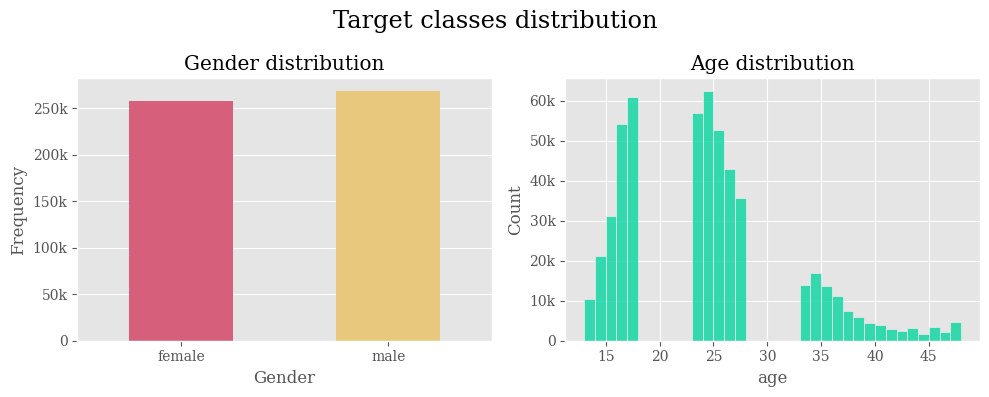

In [8]:
fig, axes = plt.subplots(1,2, figsize = (10,4))
fig_sex = sns.countplot(data=train, x='gender', palette = our_col, saturation=0.7, width=0.5, ax=axes[0])
fig_sex.set(title='Gender distribution', xlabel='Gender', ylabel='Frequency',
             yticklabels=(['0','50k','100k','150k','200k','250k']))
fig_age = sns.histplot(train, x = "age", color=our_col[2], alpha = 0.8, binwidth=1, ax = axes[1])
fig_age.set(title="Age distribution",yticklabels=(['0','10k','20k','30k','40k','50k','60k']))
fig.suptitle("Target classes distribution",fontsize =  'xx-large')
plt.tight_layout()
plt.savefig("plots/targetclass.png")


## 1. Counts and lengths

### Character Count

In [9]:
# New column for the length of the posts.
train['length'] = train['post'].apply(len)

In [10]:
# Cut in classes 
train['age_class'] = pd.cut(
        train["age"],
        bins=[12, 18, 28, 50],
        labels=[0, 1, 2]
    ).astype("int")
#check
train["age_class"].value_counts()

1    250672
0    177940
2     98200
Name: age_class, dtype: int64

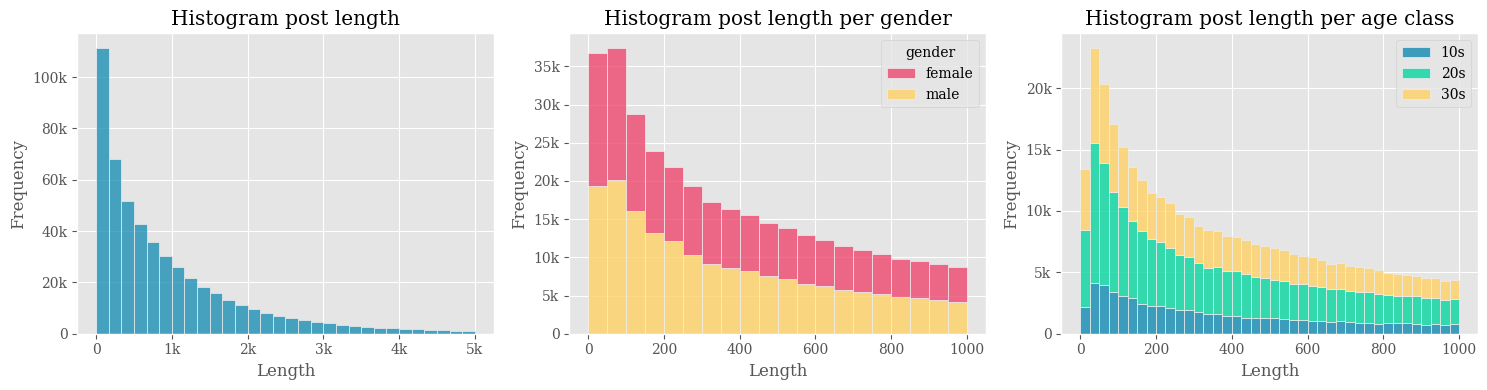

In [14]:
fig, axes = plt.subplots(1,3, figsize = (15,4))
fig_len = sns.histplot(train[train.length <= 5000], x = "length", bins = 30, color=our_col[3], ax=axes[0])
#, stat = "frequency" per avere le frequenze relative e non assolute
fig_len.set(title='Histogram post length', xlabel='Length', ylabel='Frequency',
         yticklabels=(['0','20k','40k','60k','80k','100k']), 
         xticklabels=(['0','0','1k','2k','3k','4k','5k'])
         )
fig_len_gen = sns.histplot(train[train.length <= 1000], x = "length",hue='gender', binwidth=50, palette=our_col[0:2], alpha = 0.8, multiple="stack", ax = axes[1])
#, stat = "frequency" per avere le frequenze relative e non assolute
fig_len_gen.set(title='Histogram post length per gender', xlabel='Length', ylabel='Frequency',
                yticklabels=(['0','5k','10k','15k','20k','25k','30k','35k']))

fig_len_age = sns.histplot(train[train.length <= 1000], x = "length",hue='age_class',binwidth=25, palette=our_col[1:4], alpha = 0.8, multiple="stack", ax = axes[2])
#, stat = "frequency" per avere le frequenze relative e non assolute
fig_len_age.set(title='Histogram post length per age class', xlabel='Length', ylabel='Frequency',
                yticklabels=(['0','5k','10k','15k','20k']))
plt.legend(labels=["10s","20s","30s"])
plt.tight_layout()
plt.savefig("plots/postlength.png")


### Word Count

In [15]:
# Adding a new colums with the number of word for the number of words in every post.
# Different from Lenght because is not the numbers of characters.
train['word_count'] = train['post'].apply(lambda x: len(str(x).split()))
print(train[train['age_class']==0]['word_count'].mean()) # 12 - 17 tweets
print(train[train['age_class']==1]['word_count'].mean()) # 18 - 29 tweets
print(train[train['age_class']==2]['word_count'].mean()) # 29 - 50 tweets

190.02078228616386
205.92256015829452
215.80631364562117


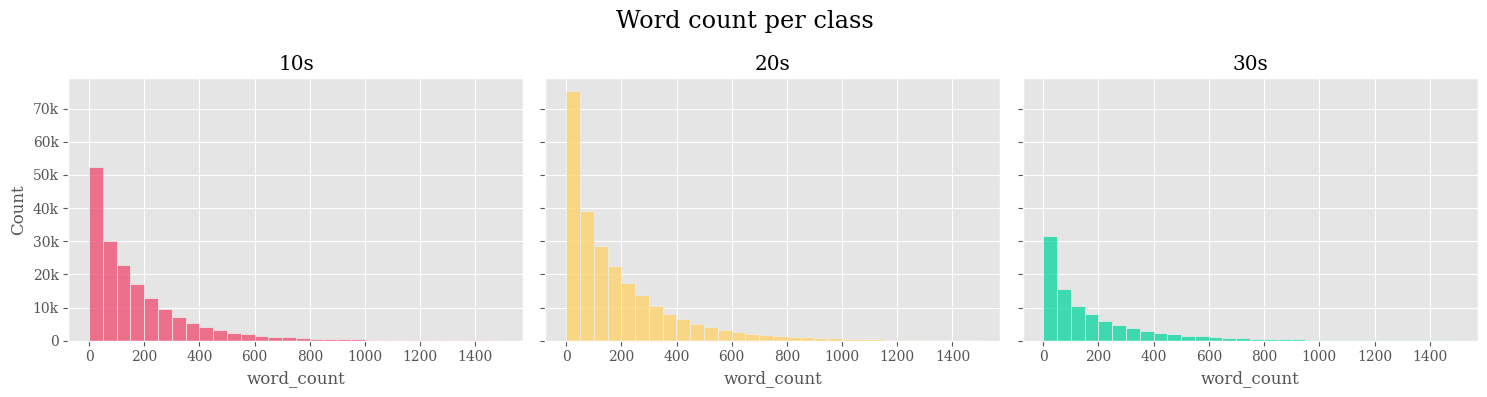

In [42]:
train[train.age_class==0]['word_count'].max() #115370 
train[train.age_class==1]['word_count'].max() #69208
train[train.age_class==2]['word_count'].max() #131169
#weeeel very big, maybe they are outliers...

# These histograms are only up to 1500 words because few tweets have more than this number but there are some tweet with a loooots of words.
fig, axes = plt.subplots(1,3, figsize = (15,4), sharey=True)
fig_0 = sns.histplot(train[train.age_class==0][train.word_count < 1500], x = "word_count", bins = 30, color=our_col[0], ax=axes[0]).set(title = "10s",yticklabels = (['0','10k','20k','30k','40k','50k','60k','70k']))
fig_1 = sns.histplot(train[train.age_class==1][train.word_count < 1500], x = "word_count", bins = 30, color=our_col[1], ax=axes[1]).set(title = "20s")
fig_2 = sns.histplot(train[train.age_class==2][train.word_count < 1500], x = "word_count", bins = 30, color=our_col[2], ax=axes[2]).set(title = "30s")
fig.suptitle("Word count per class",fontsize = "xx-large")
plt.tight_layout()
plt.savefig("plots/word_count_perclass.png")

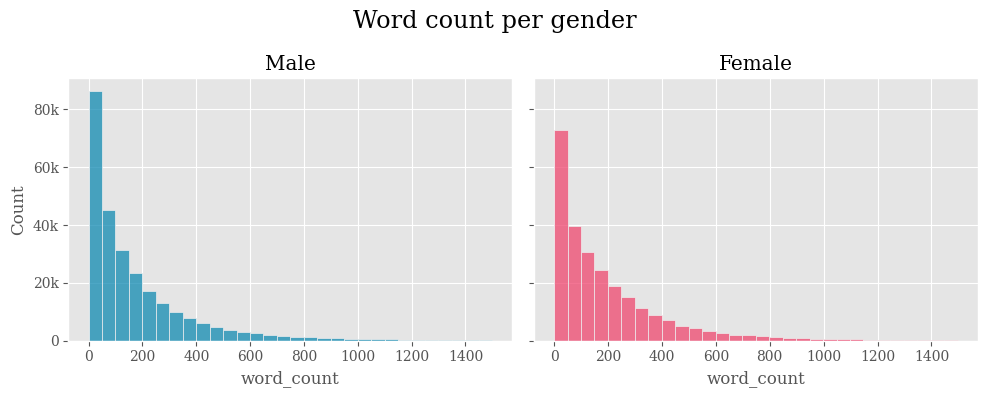

In [43]:
fig, axes = plt.subplots(1,2, figsize = (10,4), sharey=True)
fig_0 = sns.histplot(train[train.gender == "male"][train.word_count < 1500], x = "word_count", bins = 30, color=our_col[3], ax=axes[0]).set(title = "Male",yticklabels = (['0','20k','40k','60k','80k']))
fig_1 = sns.histplot(train[train.gender=="female"][train.word_count < 1500], x = "word_count", bins = 30, color=our_col[0], ax=axes[1]).set(title = "Female")
fig.suptitle("Word count per gender",fontsize = "xx-large")
plt.savefig("plots/word_count_perGender.png")
plt.tight_layout()

### Sentence Count

In [17]:
# Sentence counts
train["sent_count"] = train["post"].map(lambda x: len(sent_tokenize(x)))
# Average word length
train["avg_word_len"] = train["post"].map(lambda x: np.mean([len(w) for w in str(x).split()])).fillna(0)
# Average sentence length
train["avg_sent_len"] = train["post"].map(lambda x: np.mean([len(w.split()) for w in sent_tokenize(x)])).fillna(0)
#take ages to run (8 minutes ahahah)

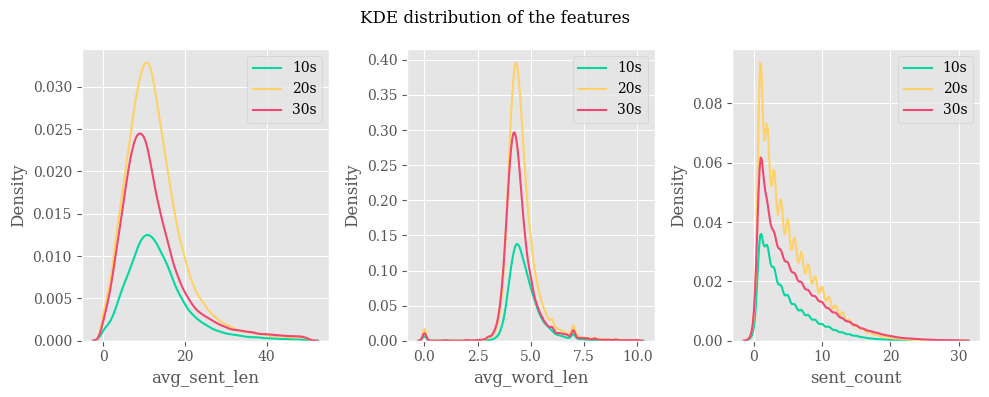

In [44]:
#Too many outliers, need less data.
train_small = train.loc[train["length"]<1000] #Almost all post are under 1000
train_small_sent_count = train_small[train_small.sent_count <= 30] # to make possible see the differences
train_small_avg_word = train_small[train_small.avg_word_len <= 10]
train_small_avg_sent = train_small[train_small.avg_sent_len <= 50]

# KDE plot
# (Kernel density estimate)
# KDE represents the data using a continuous probability density curve in one or more dimensions.
fig, axes = plt.subplots(figsize=(10,4), ncols=3, nrows=1)
sns.kdeplot(data = train_small_avg_sent, x = "avg_sent_len", ax = axes[0], label = "Average sentence length", hue="age_class", palette = our_col[0:3])
axes[0].legend(labels=["10s", "20s", "30s"])
sns.kdeplot(data = train_small_avg_word, x = "avg_word_len", ax = axes[1], label = "Average word length", hue="age_class", palette = our_col[0:3])
axes[1].legend(labels=["10s", "20s", "30s"])
sns.kdeplot(data = train_small_sent_count, x = "sent_count", ax = axes[2], label = "Sentence count", hue="age_class", palette = our_col[0:3])
axes[2].legend(labels=["10s", "20s", "30s"])
fig.suptitle("KDE distribution of the features")
plt.tight_layout()
plt.savefig("plots/kde_perclass.png")

#15 sec to run

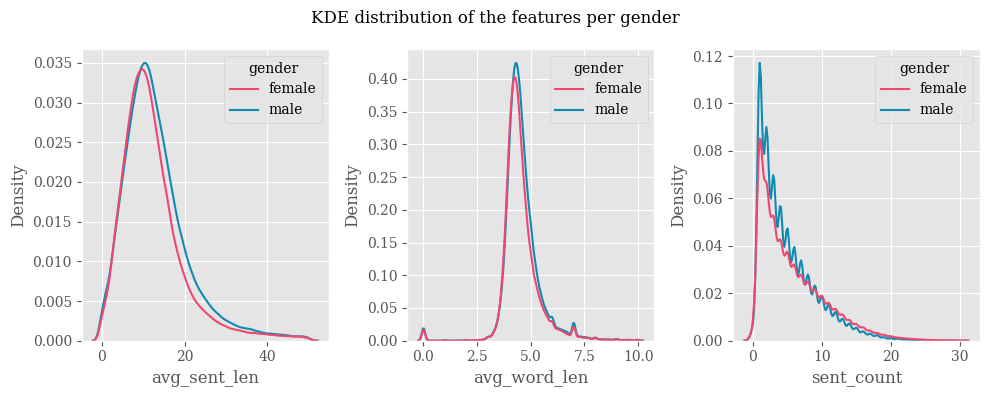

In [45]:
fig, axes = plt.subplots(figsize=(10,4), ncols=3, nrows=1)

sns.kdeplot(data = train_small_avg_sent, x = "avg_sent_len", ax = axes[0], label = "Average sentence length", hue="gender", palette = [our_col[0],our_col[3]])
sns.kdeplot(data = train_small_avg_word, x = "avg_word_len", ax = axes[1], label = "Average word length", hue="gender", palette = [our_col[0],our_col[3]])
sns.kdeplot(data = train_small_sent_count, x = "sent_count", ax = axes[2], label = "Sentence count", hue="gender", palette = [our_col[0],our_col[3]])
fig.suptitle("KDE distribution of the features per gender")
plt.tight_layout()
plt.savefig("plots/kde_perGender.png")

# Preprocessing | Text Cleaning

##### 0. Expand Contractions

We noticed that it is better to expand the contractions at the begginning, before lowering the case

In [46]:
# https://towardsdatascience.com/text-normalization-for-natural-language-processing-nlp-70a314bfa646
# Not as efficient as other specialized packets... bu at least it works well
contractions_dict = {"ain’t": "are not", "'s":" is", " s ":" is", "aren’t": "are not", "Aren't": "are not", "can’t": "cannot", "can’t’ve": "cannot have", "‘cause": "because", "could’ve": "could have", "couldn’t": "could not", "couldn’t’ve": "could not have", "didn’t": "did not", "doesn’t": "does not", "don't": "do not", "don t": "do not", "hadn’t": "had not", "hadn’t’ve": "had not have", "hasn’t": "has not", "haven’t": "have not", "he’d": "he would", "he’d’ve": "he would have", "he’ll": "he will", "he’ll’ve": "he will have", "how’d": "how did", "how’d’y": "how do you", "how’ll": "how will", "I’d": "I would", "I’d’ve": "I would have", "I’ll": "I will", "i'll": "i will", "'ll":" will", "I’ll’ve": "I will have", "I’m": "I am", "i'm": "i am", "'m": " am", "im": "i am", "I’ve": "I have", "i've": "i have", "isn’t": "is not", "it’d": "it would", "it’d’ve": "it would have", "it’ll": "it will", "it’ll’ve": "it will have", "let’s": "let us", "ma’am": "madam", "mayn’t": "may not", "might’ve": "might have", "mightn’t": "might not", "mightn’t’ve": "might not have", "must’ve": "must have", "mustn’t": "must not", "mustn’t’ve": "must not have", "needn’t": "need not", "needn’t’ve": "need not have", "o’clock": "of the clock", "oughtn’t": "ought not", "oughtn’t’ve": "ought not have", "shan’t": "shall not", "sha’n’t": "shall not", "shan’t’ve": "shall not have", "she’d": "she would", "she’d’ve": "she would have", "She'll": "she will", "she’ll": "she will", "she’ll’ve": "she will have", "should’ve": "should have", "shouldn’t": "should not", "shouldn’t’ve": "should not have", "so’ve": "so have", "that’d": "that would", "that’d’ve": "that would have", "there’d": "there would", "there’d’ve": "there would have", "they’d": "they would", "they’d’ve": "they would have","they’ll": "they will",
  "they’ll’ve": "they will have", "they’re": "they are", "they’ve": "they have", "to’ve": "to have", "wasn’t": "was not", "we’d": "we would", "we’d’ve": "we would have", "we’ll": "we will", "we’ll’ve": "we will have", "we’re": "we are", "we’ve": "we have", "weren’t": "were not","what’ll": "what will", "what’ll’ve": "what will have", "what’re": "what are", "what’ve": "what have", "when’ve": "when have", "where’d": "where did", "where’ve": "where have",
  "who’ll": "who will", "who’ll’ve": "who will have", "who’ve": "who have", "why’ve": "why have", "will’ve": "will have", "won’t": "will not", "won’t’ve": "will not have", "would’ve": "would have", "wouldn’t": "would not", "wouldn’t’ve": "would not have", "y’all": "you all", "y’all’d": "you all would", "y’all’d’ve": "you all would have", "y’all’re": "you all are", "y’all’ve": "you all have", "you’d": "you would", "you’d’ve": "you would have", "you’ll": "you will", "You'll": "you will", "you’ll’ve": "you will have", "You're": "you are", "you’re": "you are", "you’ve": "you have", "wanna": "want to", " u ": " you", " r ": " are ", "gawd": "god", "urlLink": "", "luv": "love", "wuts": "what is", "wasnt": "was not", "Wasnt": "was not"}

In [48]:
#takes 2 minutes to run
contractions_re = re.compile('(%s)'%'|'.join(contractions_dict.keys()))

def expand_contractions(s, contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, s)

train['post'] = train.post.apply(expand_contractions)

##### 1. Convert to Lower Case

In [15]:
def lowering(text):
    return text.lower()

train['post'] = train.post.apply(lowering)   
train.head()

,post,age,gender,length,age_class,word_count,sent_count,avg_word_len,avg_sent_len
0,ooh shiny new commenting!,16,female,25,0,4,1,5.500000,4.000000
1,so what is up? today i had the parade. suked. ...,14,male,245,0,48,13,4.062500,3.692308
2,"i do not know about anyone else anymore, but i...",24,female,462,1,80,4,4.750000,20.000000
3,another roof-top sunset posted by paul,24,male,50,1,7,1,5.714286,7.000000
4,god i love my nanny! she is absolutely the gr...,23,female,3656,1,730,28,3.954795,26.071429


##### 2. Remove URLs and HTML tags

In [16]:
# First of all... do we really have any URL? Let's check:
print(len(train[train.post.str.contains('http')])) # 10 thousands posts contain reference to websites. We need to remove these websites from the texts
def remove_url(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

train['post'] = train.post.apply(remove_url)

10685


In [17]:
#print(len(train[train.post.str.contains('href=')])) # Only 88.. we can drop them

def remove_html_tags_func(text):
    return BeautifulSoup(text, 'html.parser').get_text()

##### 3. Remove strange accented characters

In [18]:
def remove_accents(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

train['post'] = train.post.apply(remove_accents)

##### 4. Remove Punctuation (and Numbers)

In [19]:
def remove_punctuation(text):
    # return re.sub(r'[^a-zA-Z0-9]', ' ', text) # --> if you allow for numbers
    return re.sub(r'[^a-zA-Z]', ' ', text) # --> if you do not allow for numbers

train['post'] = train.post.apply(remove_punctuation)

##### 5. Remove extra whitespaces

In [20]:
#takes 40 sec to run
def remove_extra_spaces(text):
    return re.sub(r'^\s*|\s\s*', ' ', text).strip()

train['post'] = train.post.apply(remove_extra_spaces)

##### 6. Delete Stopwords

In [21]:
# # Prima opzione: 179 parole vietate
# import nltk
# from nltk.corpus import stopwords
# sw_nltk = stopwords.words('english')

# Seconda opzione: 326
import spacy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words

In [22]:
# Delete stop words
def delete_stopwords(text):
    words = [word for word in text.split() if word.lower() not in sw_spacy]
    new_text = " ".join(words)
    return new_text

# Create new columns with new text and new length
train['post'] = train['post'].apply(delete_stopwords)

##### Ok!
We can declare the preprocessing phase completed.

##### We save this dataset in a pickle object

In [ ]:
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

In [ ]:
# sample usage
#save_object(train,'train_clean.pkl')

From now on, we will read this pickle object instead of running the whole code again

In [49]:
train = pd.read_pickle('train_features_paper.pkl')

In [50]:
train.head(5)

,post,clean_post,gender,age_class,word_count,has_emoticon,has_punctuation,has_hope,has_hehe,has_weeks,...,has_taking,has_bill,has_hey,has_saturday,has_remember,has_party,has_walking,has_share,has_brother,has_URL
0,ooh shiny commenting,ooh shiny commenting,female,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,wuts parade suked band battle kicked ass jims ...,wuts parade suked band battle kicked ass jims ...,male,0,15,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,anymore concerned everyday bold faced liar ahe...,anymore concerned everyday bold faced liar ahe...,female,1,25,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,roof sunset posted paul,roof sunset posted paul,male,1,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,gawd luv nanny absolutely greatest woman earth...,gawd luv nanny absolutely greatest woman earth...,female,1,204,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# EDA | Term Frequency Analysis

In [51]:
def most_common_words(train):
    corpus = [word for i in train["clean_post"].str.split().values.tolist() for word in i]
    most_common = FreqDist(corpus).most_common(15)
    words, frequency = [], []
    for word, count in most_common:
        words.append(word)
        frequency.append(count)   
    return words, frequency

class_0 = train[train.age_class == 0]
class_1 = train[train.age_class == 1]
class_2 = train[train.age_class == 2]

words_0,frequency_0 = most_common_words(class_0)
words_1,frequency_1 = most_common_words(class_1)
words_2,frequency_2 = most_common_words(class_2)

class_male = train[train.gender == "male"]
class_female = train[train.gender == "female"]

words_m,frequency_m = most_common_words(class_male)
words_f,frequency_f = most_common_words(class_female)


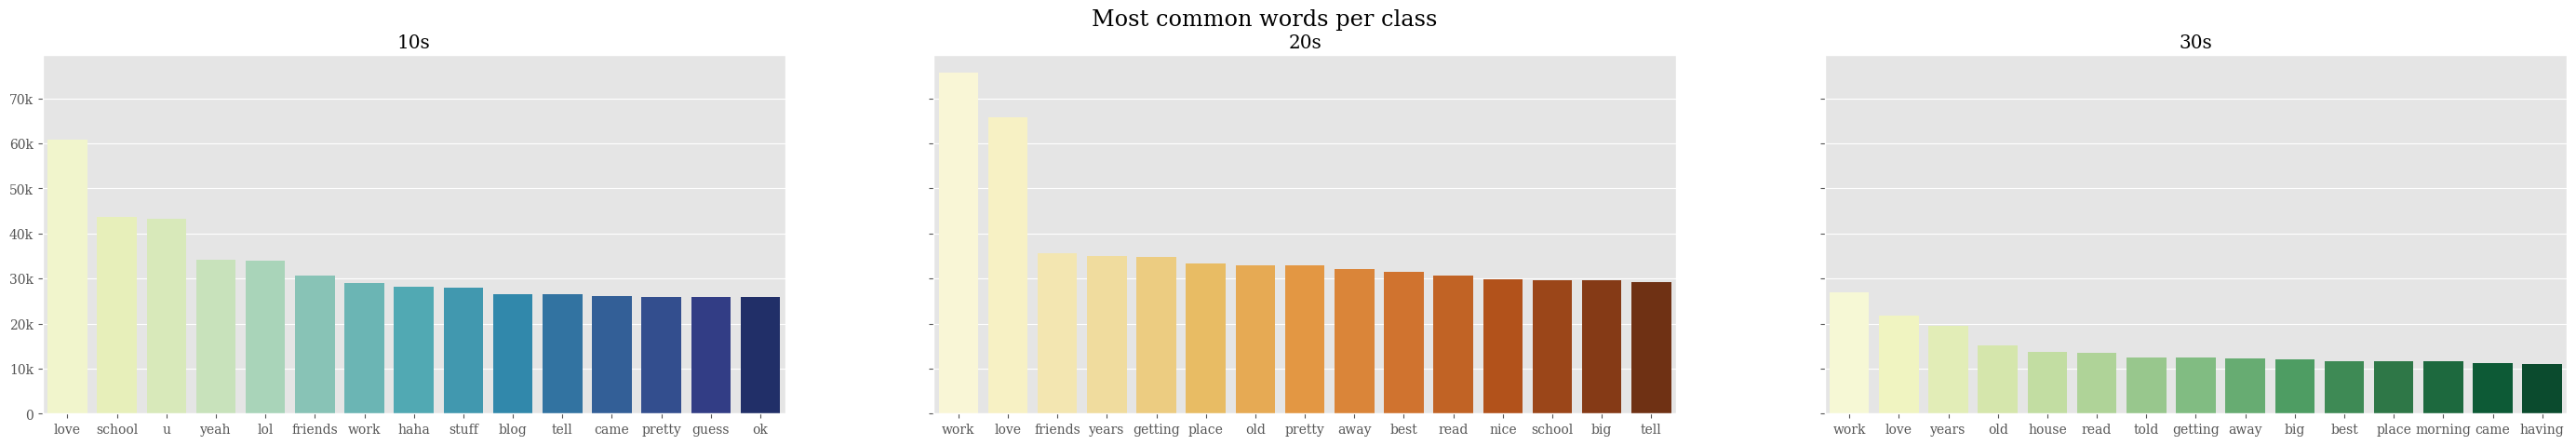

In [55]:
fig,axes = plt.subplots(1,3, sharey=True, figsize=(35,5))
plot_0 = sns.barplot(x = words_0, y = frequency_0, ax=axes[0], palette='YlGnBu').set(title="10s",yticklabels = (['0','10k','20k','30k','40k','50k','60k','70k']))
plot_1 = sns.barplot(x = words_1, y = frequency_1, ax=axes[1], palette='YlOrBr').set(title="20s")
plot_2 = sns.barplot(x = words_2, y = frequency_2, ax=axes[2], palette='YlGn').set(title="30s")
fig.suptitle("Most common words per class",fontsize = "xx-large")
plt.tight_layout
plt.savefig("plots/mostCommon_age.png")




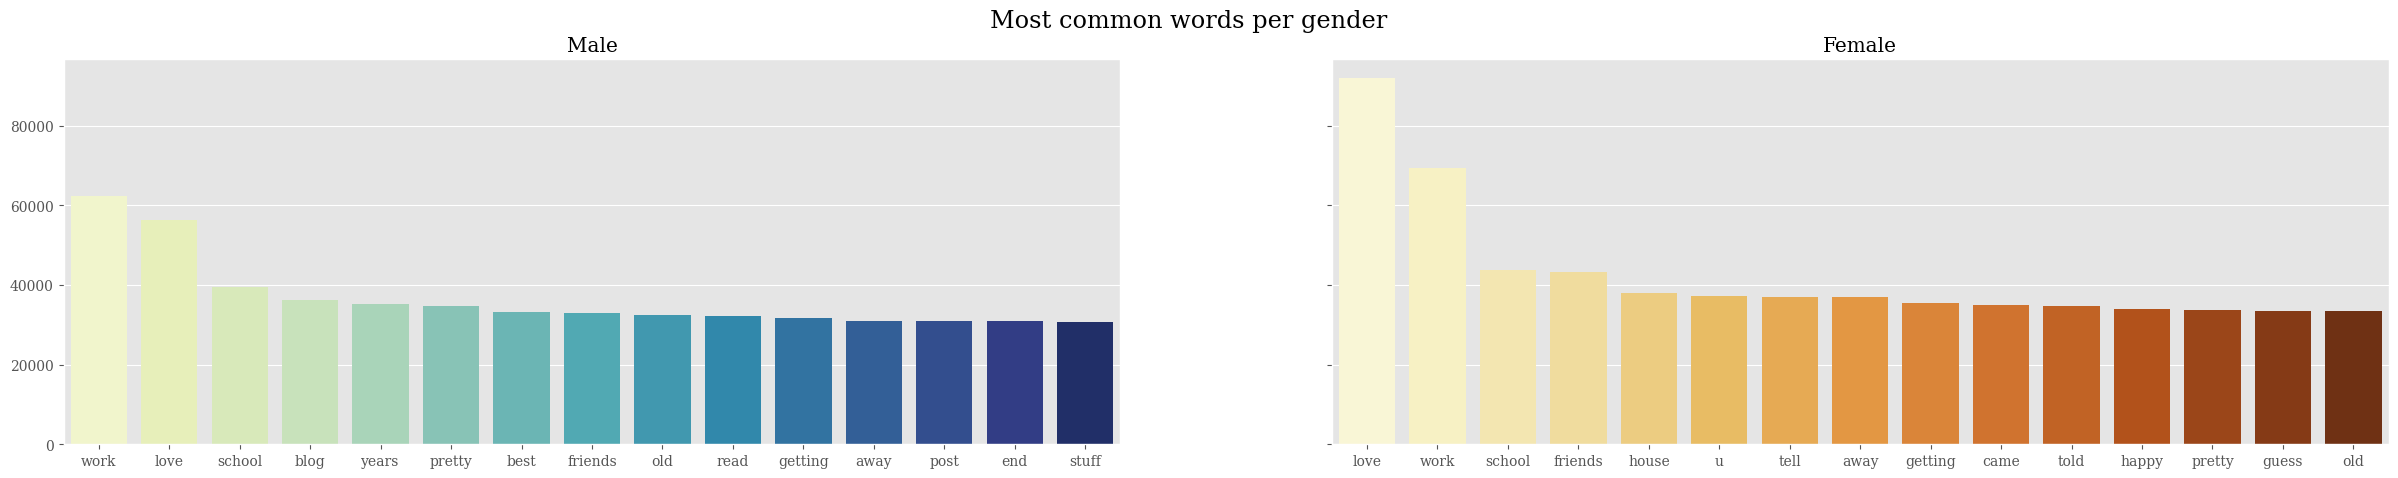

In [57]:
fig,axes = plt.subplots(1,2, sharey=True, figsize=(30,5))
plot_0 = sns.barplot(x = words_m, y = frequency_m, ax=axes[0], palette='YlGnBu').set(title="Male")# ,yticklabels = (['0','25k','50k','75k','100k','125k','150k','175k','200k']))
plot_1 = sns.barplot(x = words_f, y = frequency_f, ax=axes[1], palette='YlOrBr').set(title="Female")
fig.suptitle("Most common words per gender",fontsize = "xx-large")
plt.tight_layout
plt.savefig("plots/mostCommon_gender.png")

In [61]:
corpus = [word for i in train["clean_post"].str.split().values.tolist() for word in i]

In [62]:
bigrams = (pd.Series(nltk.ngrams(corpus, 2)).value_counts())
bigrams_df = bigrams.reset_index()
bigrams_df.columns = ['bigram', 'count']
#1 minutes to run

<Axes: xlabel='count', ylabel='bigram'>

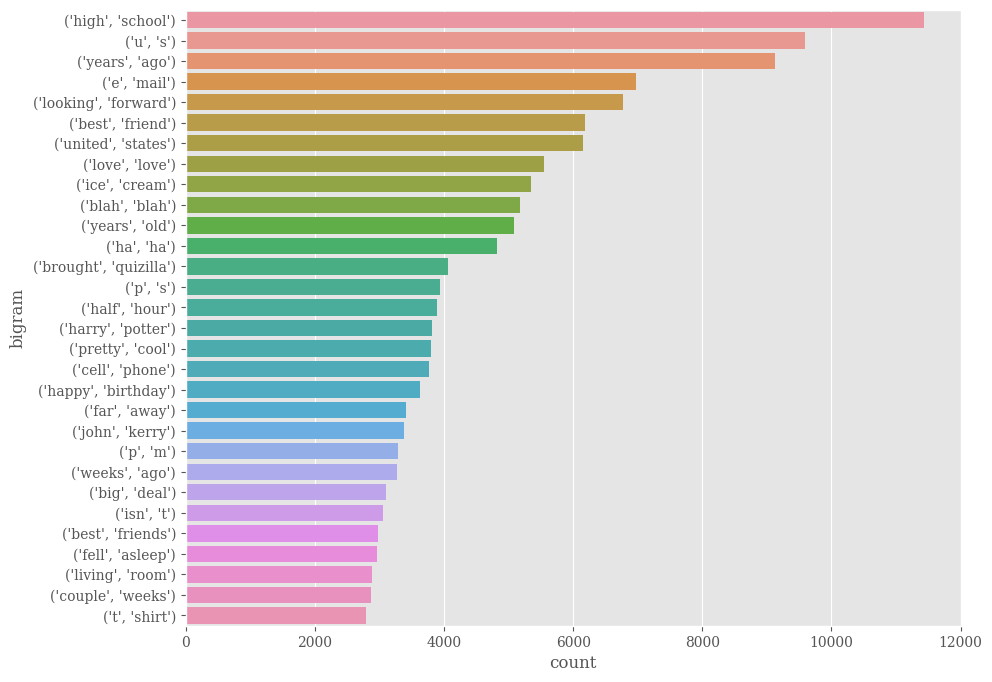

In [64]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(bigrams_df.head(30), x = 'count', y = 'bigram',ax=ax )

In [70]:
trigrams = (pd.Series(nltk.ngrams(corpus, 3)).value_counts())
trigrams_df = trigrams.reset_index()
trigrams_df.columns = ['trigram', 'count']
#2 minutes to run

<Axes: xlabel='count', ylabel='trigram'>

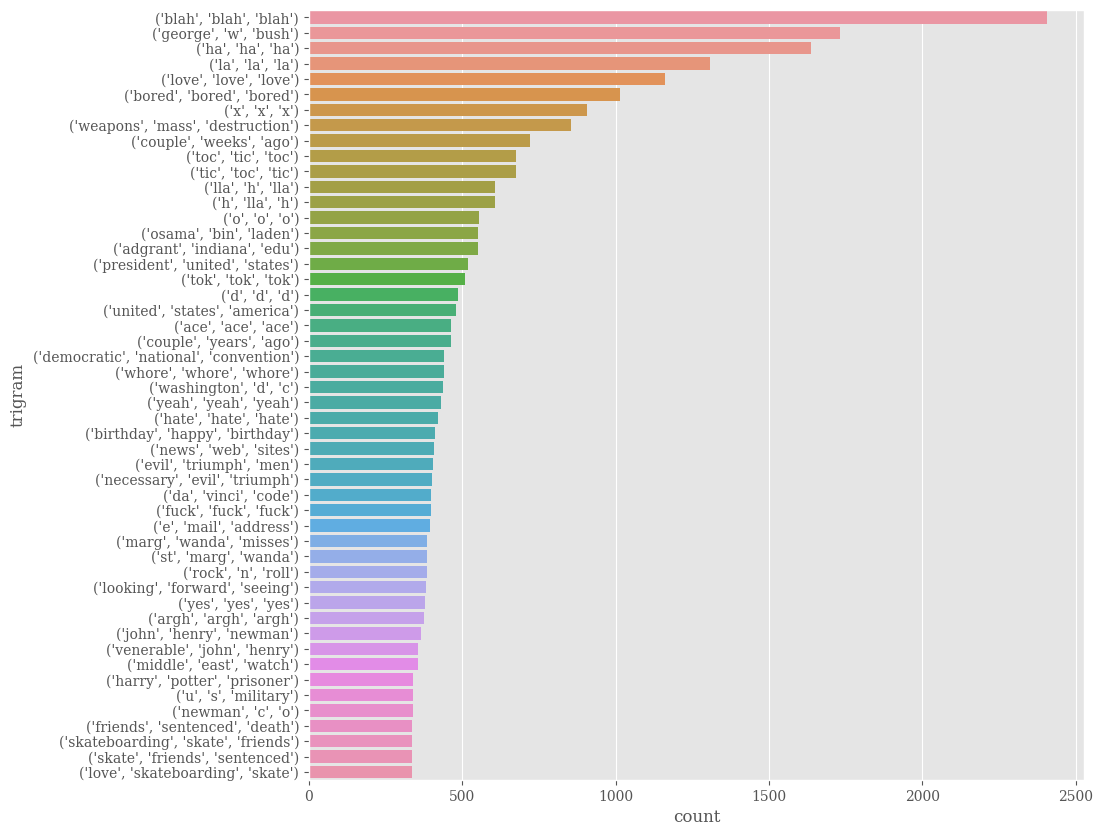

In [72]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(trigrams_df.head(50), x = 'count', y = 'trigram', ax = ax)


# Embedding using Sentence Transformers

Our main source of inspiration:
https://www.youtube.com/watch?v=c7AqnswslWo

In [ ]:
# Creiamo una mini versione del dataset per le prove...

mini_train = train[1:50]

In [ ]:
# Tokenizer

# Pipeline that is tipically used:
# -   Remove punctuation                       (done)
# -   Remove stopwords                         (done)
# -   Implement lemmatization and tokenization (TODO)

# In our particular case, it seems that we have to do the following:
# -   Lemmatize each row
# -   Embed using sentence transformers

# At the present stage, it should be easy to do.
# So, first thing first, we need to tokenize and lemmatize every sentence we have. 
# After this opearation, we should have the same exact structure of the dataset, but this time the posts will be a little bit different because of the lemmatization.

### Lemmatization

In [ ]:
# https://spacy.io/models/en

nlp = spacy.load("en_core_web_sm")

# Let's create or tokenizer function

def lemmatizer(sentence):
    doc = nlp(sentence)

    # Lemmatize:
    mytokens = [word.lemma_.strip() for word in doc]

    # Re-join
    sentence = " ".join(mytokens)

    # Return the sentence
    return(sentence)

##### Per prima cosa, facciamo la lemmatization sull'intero dataset (più di 500k righe)

In [ ]:
mini_train = train[['post', 'age', 'gender', 'new_length']]
mini_train.shape

In [ ]:
# Let's see if this works:
mini_train['lemmatize'] = mini_train['post'].apply(lemmatizer)

mini_train.head(10)

In [ ]:
# Lo salviamo in un oggetto a parte
save_object(mini_train, 'lemmatization.pkl')

### Embedding using sentence transformers

In [ ]:
lemmatization = pd.read_pickle('/Users/simonefacchiano/Desktop/Data Science/SL/Project/SL-Final-Project/lemmatization.pkl')
mini_train = lemmatization[:100000]

In [ ]:
# pip install -U sentence-transformers -q

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2') 

# https://www.sbert.net/docs/pretrained_models.html
# According to this official website, this model (all-MiniLM-L6-v2) "is 5 times faster and still offers good quality"

In [ ]:
# model.encode('Hello world')

mini_train['embedding'] = mini_train['lemmatize'].apply(model.encode)
mini_train.head()

# 10000 righe --> 6m 19s

In [ ]:
save_object(mini_train, 'embedding_100k.pkl')

# Sono tante righe...

In [ ]:
embedding = pd.read_pickle('/Users/simonefacchiano/Desktop/Data Science/SL/Project/embedding_100k.pkl')

# TEST

In [ ]:
# Import data
test = pd.read_json('test.json')

# Let's have a look at out data
print(test.head())
print('')
print(test.shape)

In [ ]:
test.age.value_counts()